In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

In [2]:
def plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3):
    """
        Рисует картинку для прогнозов
            modelt - модель 
            y_train, X_train - обучающая выборка
            y_test, X_test - тестовая выборка
            margin - граница рисунка 
    """
    
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    plt.scatter(y_train, model.predict(X_train), color="red", alpha=0.1)
    plt.xlim(min(y_train) - margin, max(y_train) + margin)
    plt.ylim(min(y_train) - margin, max(y_train) + margin)
    plt.title('Train set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)

    plt.subplot(122)
    plt.scatter(y_test, model.predict(X_test), color="red", alpha=0.1)
    plt.xlim(min(y_test) - margin, max(y_test) + margin)
    plt.ylim(min(y_test) - margin, max(y_test) + margin)
    plt.title('Test set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)
    pass

# 1. Данные

In [3]:
!ls

cian_data_v1.csv       download_hrefs.ipynb   models_v1.ipynb
cian_info.py           download_info.ipynb    unite_raw_data.ipynb
data                   href_data_raw          week01&02_parsers
data_prep_filipp.ipynb hrefs_total.pickle     week04&05_w2v


In [4]:
dff = pd.read_csv('cian_data_v1.csv', sep='\t')
# dff.head()
dff.shape

(35109, 38)

In [5]:
dff.drop('комнаты', axis=1, inplace=True)

var_cat = ['Отделка', 'Газоснабжение', 'Планировка', 'Мусоропровод', 'Парковка',
           'Тип перекрытий', 'Отопление', 'Вид из окон', 'Ремонт', 'Тип дома', 
           'Тип жилья', 'балконы', 'лоджии',   'санузлы_раздельные','санузлы_совместные', 
           'лифты_пас', 'лифты_гр'] 

var_cat = var_cat + ['is_reinovation', 'первый_этаж', 'последний_этаж']

var_teh = ['адрес', 'описание', 'href', 'lat', 'long']
target = 'цена'

var_real_nolog = ['metro_walk_min', 'metro_auto_min']
var_real_log = list(set(dff.columns) - set(var_cat) - set(var_teh) - set(var_real_nolog) - {target})

var_real = var_real_nolog + var_real_log

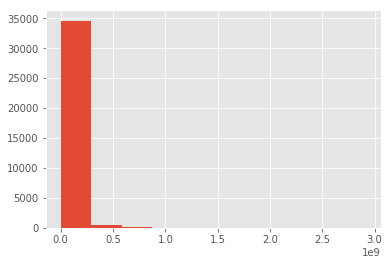

In [6]:
dff[target].hist();

In [7]:
df = dff[var_real + var_cat + [target]]
text = dff['описание']

# 2. Картинки красивые

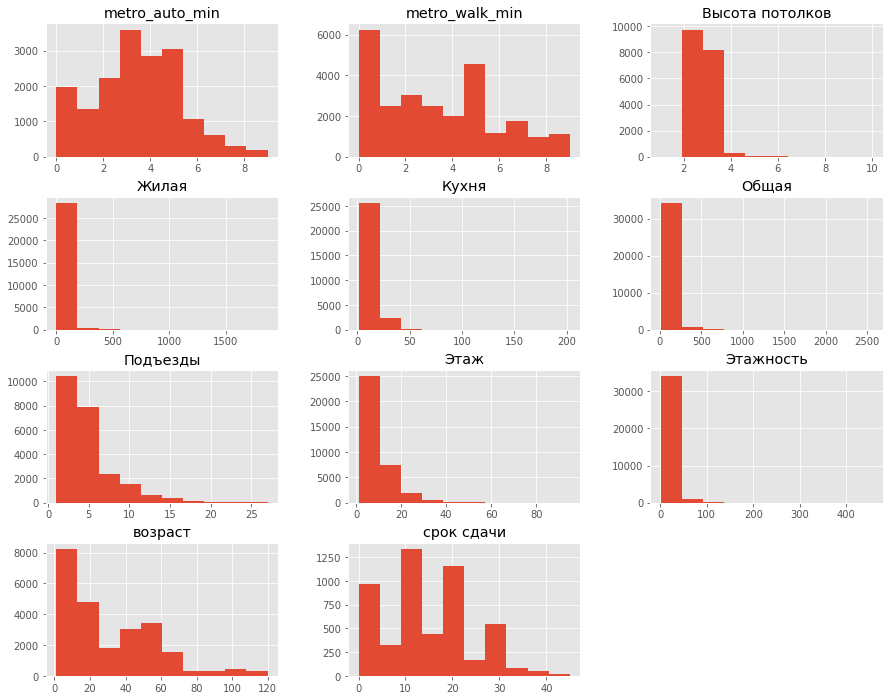

In [8]:
df[var_real].hist(figsize=(15,12));

In [9]:
df[var_real].isnull().sum()

metro_walk_min      9382
metro_auto_min     17904
Жилая               6378
Общая                  1
Кухня               6824
Подъезды           11610
Этажность              0
возраст            10879
Этаж                   0
срок сдачи         30024
Высота потолков    16794
dtype: int64

In [10]:
df['Высота потолков'].fillna(2.7, inplace=True)
df['срок сдачи'].fillna(0, inplace=True)
df['возраст'].fillna(0, inplace=True)


nanes = df[var_real_log].isnull().sum()
nanes_ind = nanes[nanes > 0].index

for name in list(nanes_ind) + var_real_nolog:
    md = df[name].median()
    df[name].fillna(md, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [11]:
df[var_real_log] = df[var_real_log].apply(lambda w: np.log(w + 1))

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


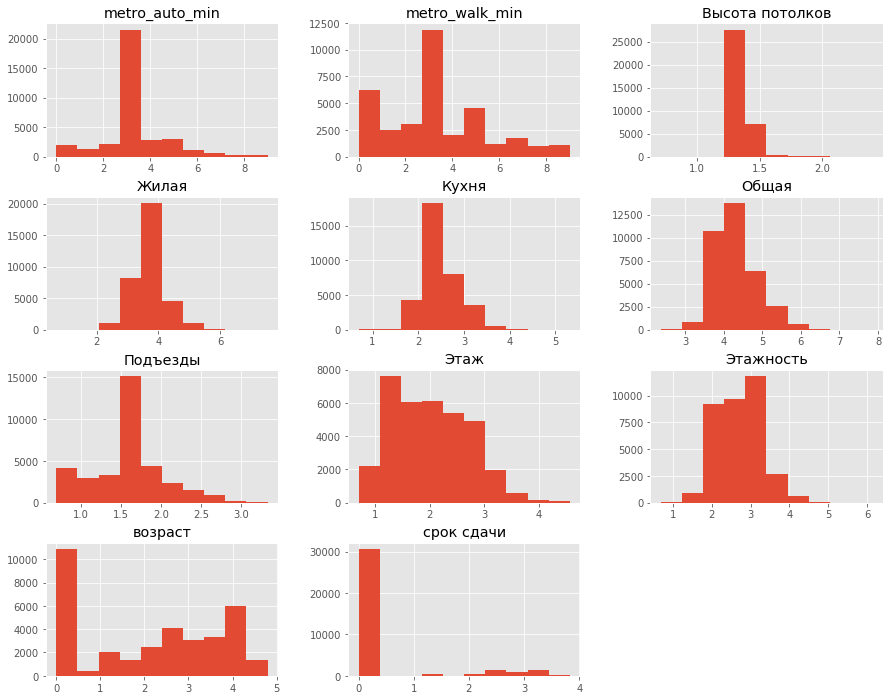

In [12]:
df[var_real].hist(figsize=(15,12));

In [13]:
df.shape

(35109, 32)

In [14]:
df = pd.get_dummies(df)#, dummy_na=True, drop_first=True)
df.shape

(35109, 71)

In [ ]:
# plt.figure(figsize=(15,12))
# sns.pairplot(df[var_real + [target]].sample(2000))

In [ ]:
# ещё картинки ? 

# 4. Модели 

In [15]:
df['цена'].max()/10**6

2911.734

In [16]:
df['цена'].quantile(0.95)/10**6

125.0

In [17]:
text = text[df['цена'] <= df['цена'].quantile(0.95)]
df = df[df['цена'] <= df['цена'].quantile(0.95)]

In [21]:
from sklearn.metrics import mean_absolute_error as mae

from sklearn.model_selection import train_test_split

y = np.log(df['цена'].to_numpy() + 1)
X = df.drop(['цена'], axis=1).to_numpy()

features_names = list(df.drop('цена', axis=1).columns)

X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(X, y, text, test_size = 0.2)

In [22]:
# Константный прогноз 
y_naive = [np.exp(np.median(y_train))]*y_test.size
mae(np.exp(y_test), y_naive)/10**6

12.989769576375355

In [23]:
# Линейная регрессии 
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.001) 
model.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
# from sklearn.model_selection import GridSearchCV

# parameters_grid = {
#     'alpha' : [10**(i) for i in range(-10,10)]
# }

# gridsearch = GridSearchCV(Lasso(), parameters_grid, scoring = 'neg_mean_absolute_error', cv = 5)

# gridsearch.fit(X_train, y_train)
# print("Лучшее значение параметра: {}".format(gridsearch.best_params_))
# print("Качество на cv: {}".format(gridsearch.best_score_))

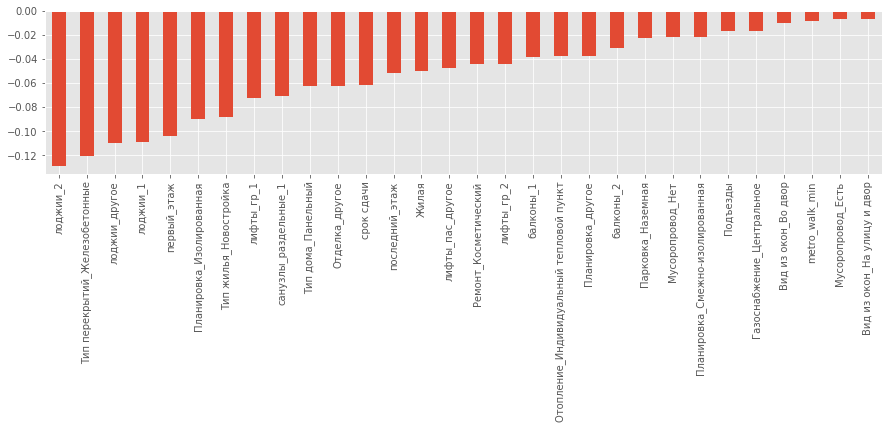

In [25]:
df_coef = pd.DataFrame(model.coef_, features_names)
df_coef[0].sort_values()[:30].plot(figsize=(15, 3), kind='bar');

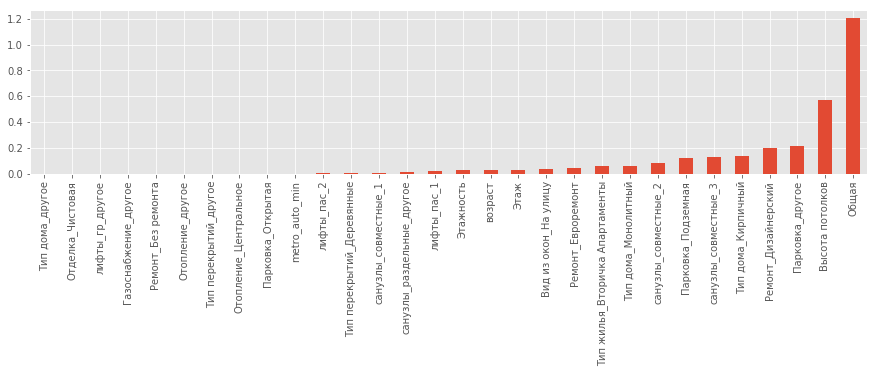

In [26]:
df_coef[0].sort_values()[-30:].plot(figsize=(15, 3), kind='bar');

In [27]:
y_pred = model.predict(X_test)
mae(np.exp(y_test), np.exp(y_pred))/10**6

6.2814960915689575

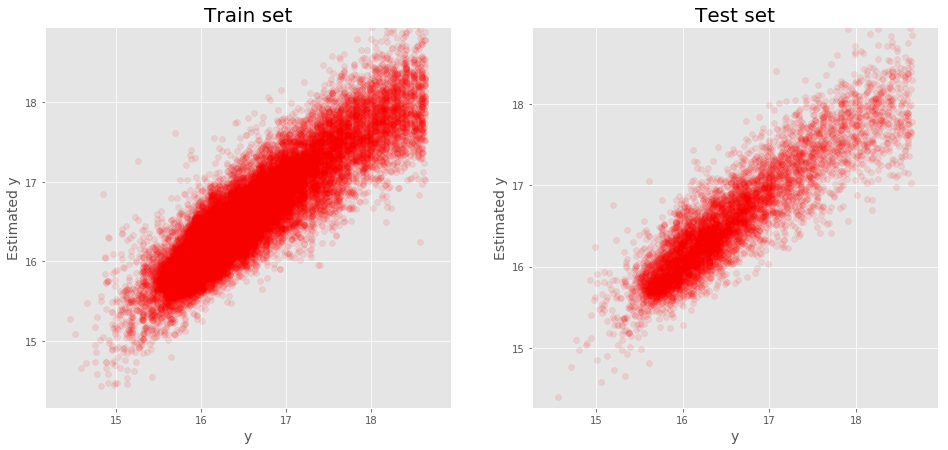

In [28]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3)

In [29]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, criterion='mse')
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [30]:
y_pred = rf.predict(X_test)
mae(np.exp(y_test), np.exp(y_pred))/10**6

4.514005980000516

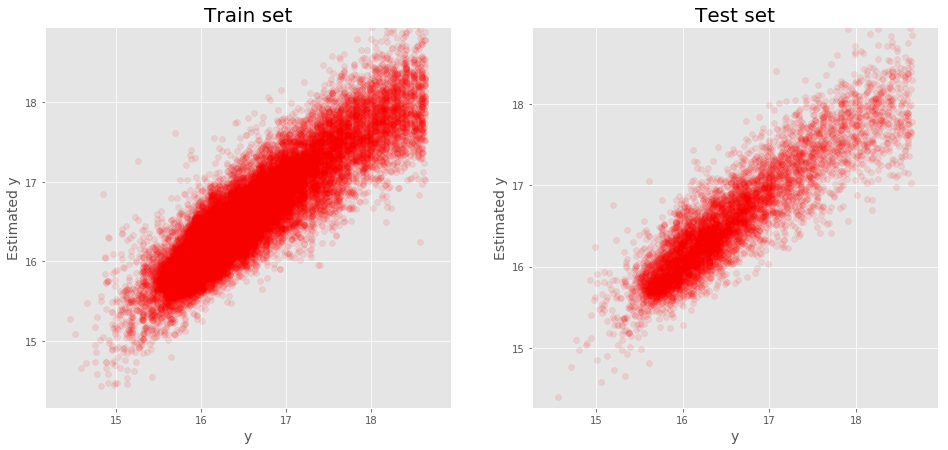

In [31]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3)

# Tf-idf на текстах

In [38]:
import string
import re

from pymorphy2 import MorphAnalyzer
m = MorphAnalyzer()

from nltk.corpus import stopwords
stopwords_ru = stopwords.words('russian') 

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

def prepare_text(text):
    tokens = word_tokenize(text.lower())
    clean_tokens = [m.normal_forms(word)[0]  for word in tokens if (word not in stopwords_ru) and 
                         (len(re.sub('[' + string.punctuation + ']', '', word)) > 1)]
    return ' '.join(clean_tokens)

In [42]:
from tqdm import tqdm
from joblib import Parallel, delayed

# n_jobs = -1
# T_train_lemm = Parallel(n_jobs=n_jobs)(delayed(prepare_text)(
#     text) for text in tqdm(T_train))

  6%|▋         | 1703/26684 [01:20<19:24, 21.44it/s]

In [97]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vect = CountVectorizer(min_df=10, max_df=0.70)
#vect = TfidfVectorizer(min_df=10, max_df=0.8)#, max_features=4000)

T_train_v = vect.fit_transform(T_train)
T_test_v = vect.transform(T_test)

In [98]:
# vect.vocabulary_
T_train_v.todense().shape

(26684, 12181)

In [106]:
from sklearn.linear_model import Lasso

model_text = Lasso(alpha=0.0001) 
model_text.fit(T_train_v, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

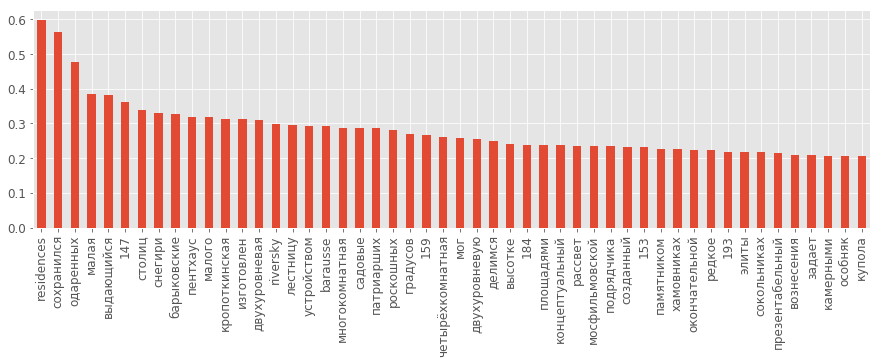

In [107]:
imps = pd.Series([cf for cf in model_text.coef_], index=vect.get_feature_names())
ip = imps.sort_values(ascending=False)[:50]
ip.plot(kind='bar', figsize=(15,4), fontsize=12);

In [108]:
y_pred = model_text.predict(T_test_v)
mae(np.exp(y_test), np.exp(y_pred))/10**6

7.752624418166711

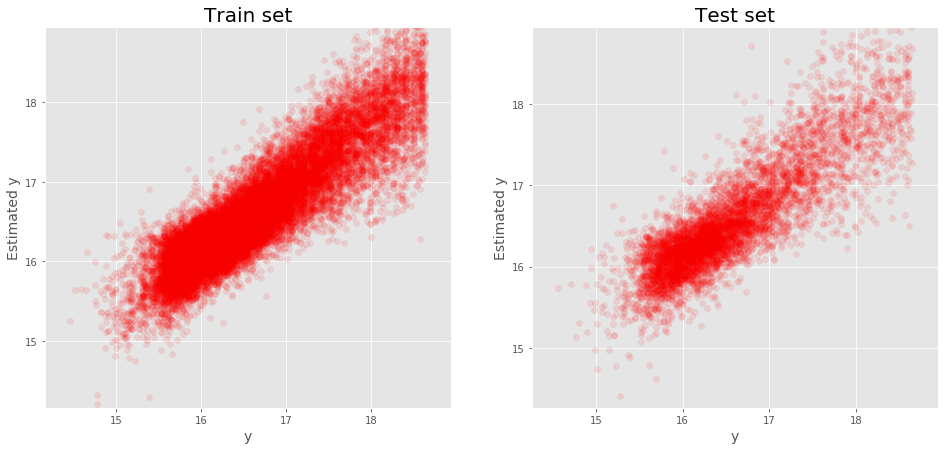

In [109]:
plot_yreal_ypred(y_test, y_train, T_test_v, T_train_v, model_text, margin=0.3)

## Ансамблик 

In [84]:
y_tx = model_text.predict(T_test_v)
y_rf = rf.predict(X_test)

In [85]:
y_test_v, y_test_t, y_tx_v, y_tx_t, y_rf_v, y_rf_t = train_test_split(y_test, y_tx, y_rf, test_size=0.5)

$$
y_p = \alpha \cdot y_{ptx} + (1 - \alpha) \cdot y_{prf}
$$

In [91]:
Yv = np.vstack((y_tx_v, y_rf_v)).T
Yt = np.vstack((y_tx_t, y_rf_t)).T

In [94]:
from sklearn.linear_model import LinearRegression

model_ans = LinearRegression()
model_ans.fit(Yv, y_test_v)
model_ans.coef_

array([0.31243689, 0.79600785])

In [95]:
y_predict_ans = model_ans.predict(Yt)

In [96]:
mae(np.exp(y_test_t), np.exp(y_predict_ans))/10**6

4.34648359783962

- Поделать сложные модели по кластерам + специфическое обучение 
- Как не подгружать данные в оперативку 
- Ансамбли
- Залезть в лес
- Sparse matrix какикие бывают форматы